# Predicting Youtube View Count in 2007/2008

### Introduction

After being acquired by Google in 2006, Youtube obtained a rapid growth in popularity resulting in a growing community. In 2022, Youtube was the second most trafficked site in the world, only behind Google, sitting at 74.8 billion visited worldwide according to Statista. Some people may have wondered if they could persue Youtube as a potential career. As a result, researching about certain analytics would drive their videos to go "viral" as we know today. Youtube only displays a certain amount of data for the viewers on first glance. While certain features of Youtube have since been removed since 2007 to 2008, most notibly the rating feature, the dataset we have chosen still includes the information, and we will be utilizing it in our analysis. Below included is a screenshot of what an example Youtube webpage would look like in 2007.



<img src="https://preview.redd.it/165ijbwo32171.png?auto=webp&s=5c00315a5a37d5e6fc2c37c5ddfa58df8f295aba"
     alt="Youtube in 2007"
    width="500" height="300"/>

 **The goal of this project is to use the data of 2007 to predict the view of videos in 2008.** 

We will be using datasets from https://netsg.cs.sfu.ca/youtubedata/. This website compiles data from 2007 to 2008 of all Youtube videos crawled on their website. The process of which is described in more detail on the actual website. Just know that the key categories parsed are video ID, uploader, **age**, category, **length**, **views**, **rate**, **rating**, **comment count** and related IDs, but only the points in **bold** will be explored in this analysis.

The two days we have chosen are May 5th, 2007 and May 4th, 2008. The reason for picking these two days is bceause these days are weekends, and both should represent a normal Youtube traffick day, i.e, it is not a day in which there is a holiday or otherwise that would significantly increase Youtube view count on those specific days.
 

##### **“Discovering the major sources that drive views to a video and understanding how they impact the view growth pattern have become interesting topics for researchers as well as advertisers, media companies, or anyone who wish to have a shortcut to stardom”. (Zhou et al., 2016)**



In [ ]:
## TODO
-ways to improve model -> added a bit, maybe add more
-need to do discussion -> did not cover whether it was expected or not
-maybe log some explanatory variables -> there's infinity so get rid of them maybe(justify: outliers?)

### Methods

In [22]:
# Setup
library(tidyverse)
library(tidymodels)
library(corrplot)
library(car)
library(leaps)

── Attaching packages ────────────────────────────────────────────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.3     

── Conflicts ───────────────────────────────────────────────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ car::recode()     masks dplyr::recode()
✖ car::some()       masks purrr::some()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Use suppressPackageStartupMessages() to eliminate package startup messages



In [38]:
# Load in May 5th 2007 data
table0007 <- read.delim("data/0007.txt", header = FALSE, sep = "\t", dec = ".")
table0107 <- read.delim("data/0107.txt", header = FALSE, sep = "\t", dec = ".")
table0207 <- read.delim("data/0207.txt", header = FALSE, sep = "\t", dec = ".")
table0307 <- read.delim("data/0307.txt", header = FALSE, sep = "\t", dec = ".")

data2007 <- rbind(table0007,table0107,table0207, table0307)|> na.omit()
colnames(data2007) <- c("Video ID", "uploader", "age", 'category','length','views','rate','ratings','comments','related IDs')

# Load in May 4th 2008 data
table0008 <- read.delim("data/0008.txt", header = FALSE, sep = "\t", dec = ".")
table0108 <- read.delim("data/0108.txt", header = FALSE, sep = "\t", dec = ".")
table0208 <- read.delim("data/0208.txt", header = FALSE, sep = "\t", dec = ".")
table0308 <- read.delim("data/0308.txt", header = FALSE, sep = "\t", dec = ".")

data2008 <- rbind(table0008,table0108,table0208, table0308)|> na.omit()
colnames(data2008) <- c("Video ID", "uploader", "age", 'category','length','views','rate','ratings','comments','related IDs')


#### Wrangling data
We decide to immediately remove some of the variables presented in the datasets. This included `uploader`,`video ID`, and `related IDs` because these variables appear to be unique to the videos itself and not affect video views as a whole.

In [39]:
# Remove unnecessary data and convert category variable as factor class
data2007 <- data2007|> select(-c(1,2,10:29)) |> mutate(category = as.factor(category))
data2008 <- data2008 |>  select(-c(1,2,10:29)) |> mutate(category = as.factor(category))
head(data2007)

,age,category,length,views,rate,ratings,comments
,<dbl>,<fct>,<int>,<int>,<dbl>,<int>,<int>
1,807,Entertainment,28,1393810,4.16,1397,2888
2,808,News & Politics,133,208383,3.47,318,769
3,807,People & Blogs,28,135882,3.89,92,276
4,807,Howto & DIY,41,153590,1.58,2074,1230
5,807,Sports,99,92520,2.32,78,155
6,807,Entertainment,28,115085,3.73,84,207


**Table 1:** The dataset obtained uses a crawler to obtained video API and scrape the webpage for the remaining information.

**Age:** an integer number of days between the date when the video was uploaded and Feb.15, 2007

**Category:** string of the video category chosen by the uploader

**Length:** integer number of the video length

**Views:** integer number of the views

**Rate:** float number of the video rate

**Ratings:** integer number of the ratings

**Comments:** integer number of the comments

### Preliminary Analysis

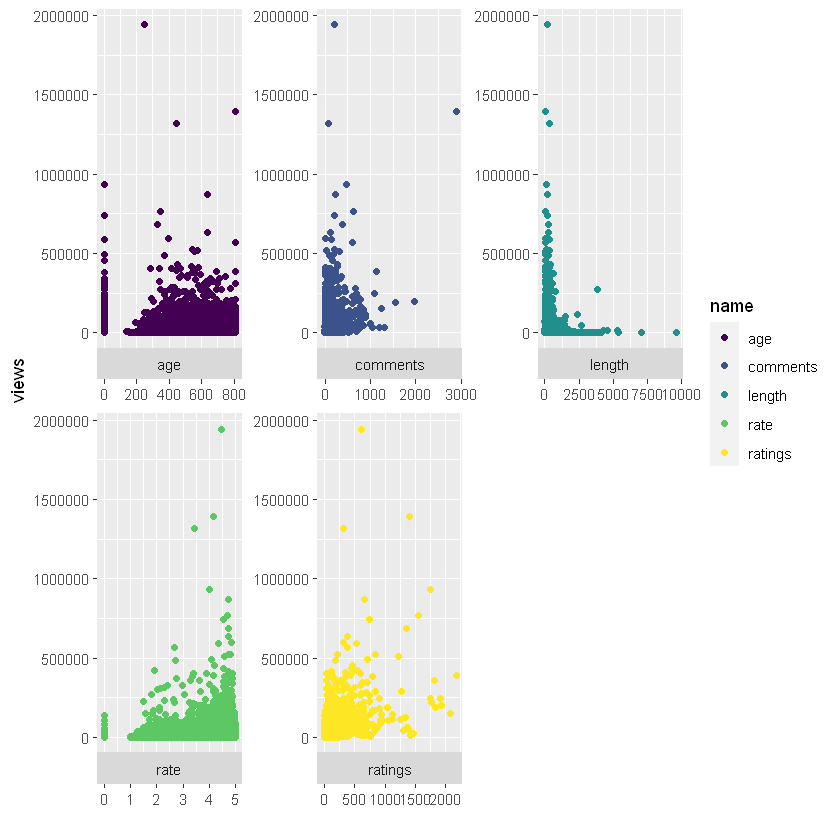

In [4]:
# Observe the explanatory variables individually against the predictor
pivot_longer(data2007,-c(views,category))|> 
    ggplot(aes(value,views,color=name)) +
    geom_point() +
    facet_wrap(~name, scales ='free',strip.position='bottom') + 
    scale_color_viridis_d() + 
    xlab("") + ylab("views")

**Figure 1:** Plot of `views` against the quantitative explanatory variables

We can observe that most variables do not a have linear relationship with the predictor variable, only `ratings` has a slight positive linear relationship. Some variables like `length` and `comments` may benefit from a logarithmic transformation.

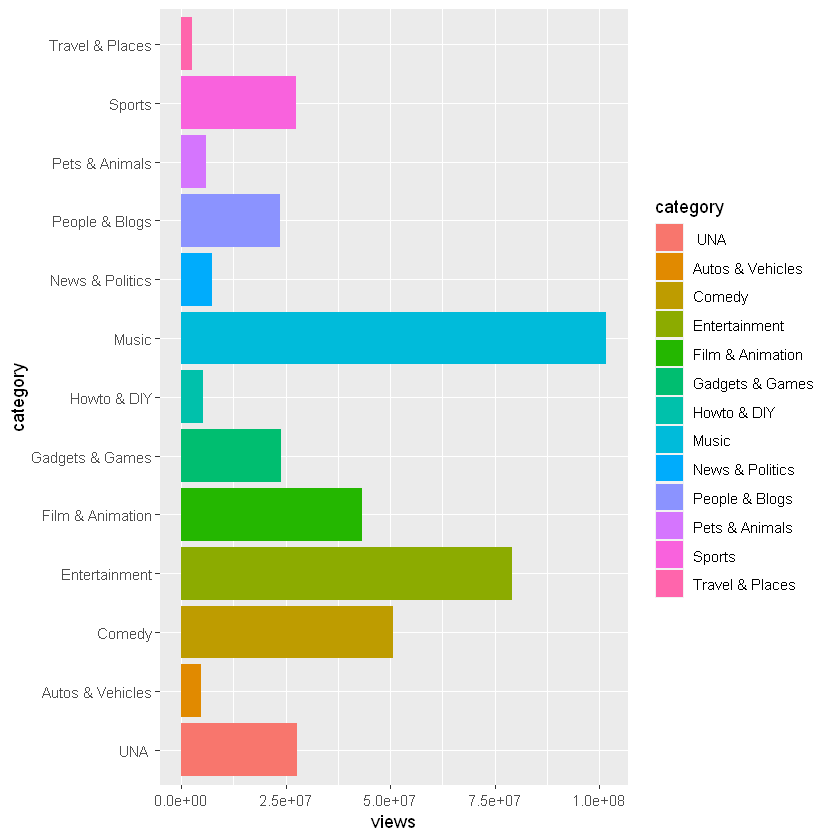

In [8]:
ggplot(data2007, aes(category,views, fill = category))+ geom_bar(stat = 'identity')+coord_flip() +
labs(x = "Views", y = "Category", fill = "Category Against Number of Views")

**Figure 2:** Plot of the number of views garnered by each type of category.

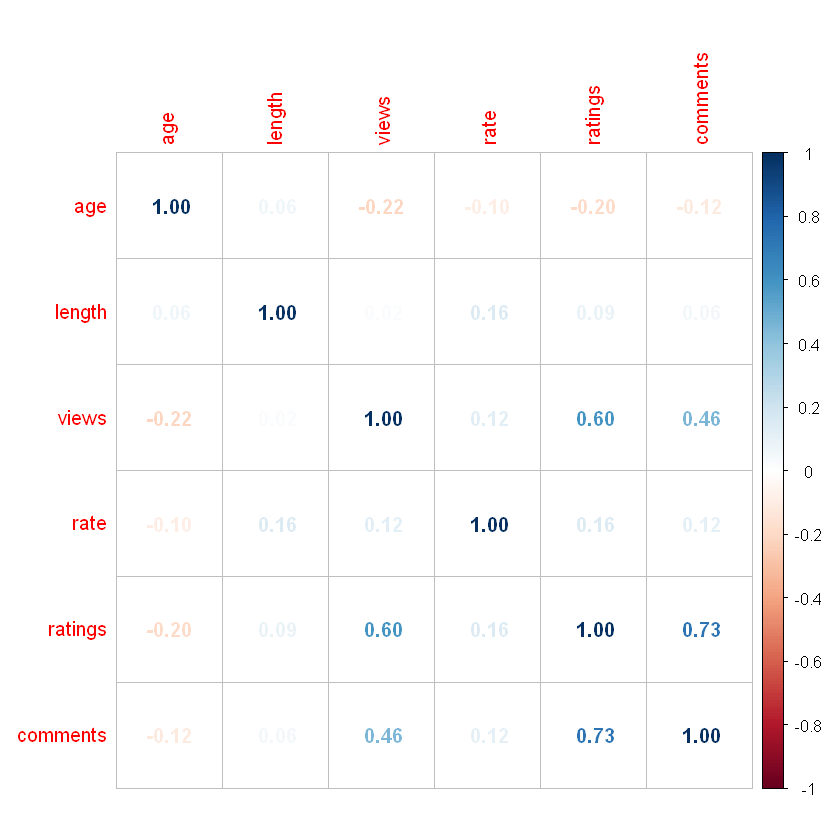

In [24]:
# Correlation plot
corrvar <- data2007|> select(-c(2))|> cor()
corrplot(corrvar, method = 'number')

**Figure 3:** Correlation plot of the predictor and the explanatory variables, excluding `category`

Taking a look at the correlation plot, we can see that `ratings` and `comments` have the strong positive relationship with the predictive variable `views`. Meanwhile, the other explanatory variables have a very weak relationship with `views`. `ratings` has a positive correlation with `view` and `comments` too. Because there are explanatory variables with correlation against each other, we check if multicollinearity is significant by taking a look at the VIF scores.

In [13]:
vif(lm(views~.,data2007))

,GVIF,Df,GVIF^(1/(2*Df))
age,1.403040,1,1.184500
category,1.456405,12,1.015789
length,1.063942,1,1.031476
rate,1.090254,1,1.044152
ratings,2.261319,1,1.503768
comments,2.168201,1,1.472481


**Table 2:** VIF values of the explanatory variables

The VIF values of the variables are not particularly big, so multicollinearity would not affect the model significantly. 

### Model Selection

In [50]:
# Find the best model for each size
bestmod <- regsubsets(views~.,data2007,method='exhaustive')
summary(bestmod)

Subset selection object
Call: regsubsets.formula(views ~ ., data2007, method = "exhaustive")
17 Variables  (and intercept)
                         Forced in Forced out
age                          FALSE      FALSE
categoryAutos & Vehicles     FALSE      FALSE
categoryComedy               FALSE      FALSE
categoryEntertainment        FALSE      FALSE
categoryFilm & Animation     FALSE      FALSE
categoryGadgets & Games      FALSE      FALSE
categoryHowto & DIY          FALSE      FALSE
categoryMusic                FALSE      FALSE
categoryNews & Politics      FALSE      FALSE
categoryPeople & Blogs       FALSE      FALSE
categoryPets & Animals       FALSE      FALSE
categorySports               FALSE      FALSE
categoryTravel & Places      FALSE      FALSE
length                       FALSE      FALSE
rate                         FALSE      FALSE
ratings                      FALSE      FALSE
comments                     FALSE      FALSE
1 subsets of each size up to 8
Selection Algorith

Looking at the selection algorithm, variables like `age`. `ratings`, and `comments` appear in most subsets. On the other hand, `category` did not appear consistently in the subsets, while `length` and `rate` were present in half of the displayed subsets.

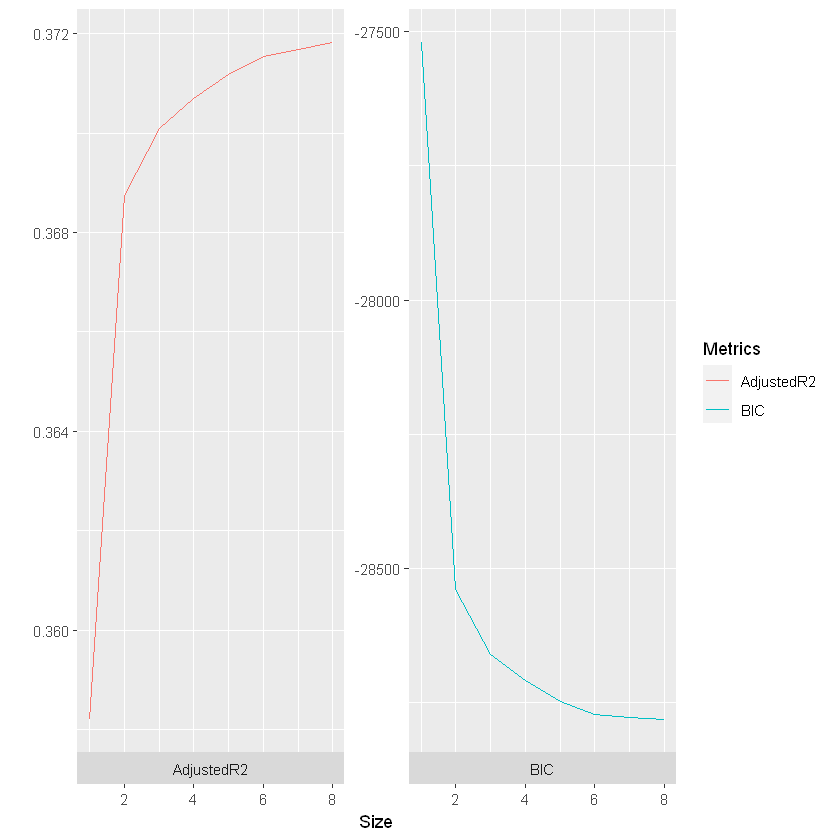

In [24]:
# Looking at some of the metrics
mydat <- as.data.frame(cbind("BIC" = summary(bestmod)$bic, 'AdjustedR2'= summary(bestmod)$adjr2, 'Size' = 1:8))
pivot_longer(mydat,-Size)|> 
    ggplot(aes(value,Size,color=name)) +
    geom_line() +
    coord_flip() +
    facet_wrap(~name, scales ='free',strip.position='bottom')+
    xlab("") + labs(colour='Metrics')

**Figure 4:** Plot of the adjusted $R^2$ and BIC values against the size of the models

A well-fitted model would have a high adjusted $R^2$ and low BIC values, but these metrics are not particularly prioritized because our end goal is prediction, so we rather prioritize reducing RMSE. However, this figure suggests a large model would fit well with the data.

### Analysis

We choose to use 2 explanatory variables: `age` and `ratings` to predict our response variable. While having a larger model would fit our data better, we hope that minimizing the number of explanatory variables will reduce RMSE.

In [82]:
# Selecting variables for reduced model
datareduced <- data2007 |>  select(c(views,age,ratings,comments))

In [86]:
# Split data into training and testing set
split <- initial_split(datareduced, prop = 3/4, strata = views)
train <- training(split)
test <- testing(split)

# Fit the regression model
lm_spec <- linear_reg() |> set_engine('lm') |> set_mode('regression')

lm_recipe <- recipe(views~., data = train)

lm_fit <- workflow() |> add_recipe(lm_recipe) |> add_model(lm_spec) |> fit(data = train)

lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)          age      ratings     comments  
   14148.62       -18.31       217.29        82.30  


Although there is a low p-value for the coefficients, the adjusted R-squared value is not particularly high and an extremely high standard error.

In [84]:
# Lets look at how well our model performed
lm_test_results <- lm_fit |> predict(test) |> bind_cols(test) |> metrics(truth = views, estimate = .pred)

lm_test_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.484785e+04
rsq,standard,3.775339e-01
mae,standard,4.754507e+03


It seems like the residual mean squared error is still enormously high, but the RMSE is smaller than that of the full model.

In [90]:
# Lets see if our model can predict the 2008 values well
data2008reduced <- data2008 |> select(c(age,ratings,comments))
predict2008 <- predict(lm_fit,data2008reduced)
head(cbind('Actual' = data2008$views,'Predicted' = predict2008))

,Actual,.pred
,<int>,<dbl>
1,57280,818177.3
2,948718,2457764.3
3,64212,325379.5
4,19193,314099.5
5,548,217027.7
6,27810,146577.5


Our predicted values are several times higher than the actual 2008 values. 

There could be many reasons for why the predicted values are significantly higher. Youtube videos being uploaded earlier is not necessary for a video to be popular. We know now based on market research that the first 48 hours of a Youtube video being uploaded is the most important. If a video has 0 views, Youtube will stop displaying the video as it does not drive traffic towards their website. If a video can make it past the 48 hours with some amount of views, it is possible to see an increase in views over the span of 3 to 6 months (Clark, 2019). Meaning that if a video does not get any views, it will likely not get any views in the future either. This would slightly impact our data analysis as there are many more videos that do not get any views than videos that do get views. Making our error values much higher than what we had assumed. 

A way in which to improve our model would be removing certain outliers of the videos that get zero to ten views, but not the upper end of videos with millions of views. The reason we would get rid of the lower view count videos is because while this is a fairly large portion of our dataset, since these videos do not get any meaningful information out of them, removing them would be better for our model. We would keep the upper end of videos as theses videos would be a good reference point for many others who want to have a video get popular on Youtube, and represent what quantitative goals people should strive for when trying to make videos.

### Future Questions

A future question this type of analysis would ultimately lead to would be something like "What is the number 1 influence over the number of views in a video?" The current trend on Youtube is for the Youtuber to say to "like" the video, which would impact the rating category, or to leave a comment, which would increase the comment count. But short videos tend to better than long videos, and songs do better than videos that are seconds long (Macmanus, R). So what's the best way to break out into the Youtube scene?

“From 2006 to 2009, most channels fall into the Music category, reaching a high in 2009 when more than 20% of all created channels would upload mainly Music videos. Entertainment, People & Blogs and Education were also continuously popular among creators during these years. However, from 2010 onwards, the majority of newly created channels were People & Blogs, coming close to 75% in 2016. Gaming started to be the second most channel category in 2012 and has remained in that place ever since.” (Bärtl, 2018)

### Citations

Zhou, R., Khemmarat, S., Gao, L., Wan, J., & Zhang, J. (2016). How YouTube videos are discovered and its impact on video views. Multimedia Tools and Applications, 75, 6035-6058.
Clark, D. (2019). How long does it take for a YouTube video to get views? How to get more views and subscribers on YouTube. from https://www.socialvideoplaza.com/en/articles/how-long-before-youtube-video-gets-views 
Bärtl, M. (2018). YouTube channels, uploads and views: A statistical analysis of the past 10 	years. Convergence, 24(1), 16-32.
Macmanus, R. (2018, October 01). Top 10 youtube videos of All Time, 2008 edition. Retrieved February 19, 2023, from https://readwrite.com/top_10_youtube_videos_of_all_time_2008/

